In [9]:
author = 'Devyash Lodha'
title = 'Search Engine - Indexing and Searching'
lastModified = '2025-02-07T20:56:17.277Z'
published = '2025-02-08T00:00:00.277Z'

Search engines are ubiquitous. Google, Bing, Yahoo, you name it, all of these are internet-wide search engines. Even your favorite social media platforms have a search functionality. How do they work? How can we build our own? And how can we build a search engine which is cheap and easy to run?

In this part of the search engine series, we will index our corpus and implement a rudimentary search on our index.

## Multipart Series 📚

1. [Introduction to the Search Problem](/blog/search-engine)
2. [Data acquisition, normalization and cleaning](/blog/search-engine-2)
3. [**Reverse Index and Search**](/blog/search-engine-3)
4. [Workshop - Build a Search Engine](/blog/search-engine-4)
5. [Workshop - Build a Search Engine (solution)](/blog/search-engine-5)

## Where we left off

In the [previous page](/blog/search-engine-1), we implemented data acquisition and data cleanup. We are now able to:

1. Find files in the directory of Enron emails
2. Clean up the text
3. Tokenize the text into lists of tokens

Our goal in this article is to take these token lists and devise a method to search through them.

## Indices 🗂️

In the first part of this series, [Introduction to the Search Problem](/blog/search-engine), we learned how to use an index in a book to find a topic. Can we use the same methods to search our **corpus**?

> 🤔 *Think to yourself*, how do you find a topic in a textbook?

> 📚 **Corpus**: In search, a corpus is simply the collection of text documents that a search engine indexes and retrieves results 

## Building an Index 📇

While writing a textbook, the authors and editors have full knowledge of the content they are writing. They have the ability to demarcate the important topics and terms, and build an index on the terms and concepts *they* think would be most useful to their readers. And this is more than enough for books! However if you are building Google, and have the lofty goal of indexing the whole internet you don't have the money, time, or capability to have a human read through every single website and article to extract the most important topics to build an index. Thus, the science behind building a search engine is about building an algorithm which can decide what to index and then efficiently build an index.

*So, how can we build an index algorithmically?*

The index in a textbook maps each entry to the pages which contain it. Example index entry:

```
A  
Antibiotics, 65-68  
Archaea, 15, 22-24  
Autotrophic bacteria, 30  

D  
DNA replication in prokaryotes, 32-34

H  
Horizontal gene transfer, 38-42  

M  
Microbiome, 60-63  
Mitochondria (Endosymbiotic Theory), 70

P  
Pathogenic bacteria, 55-58  
Plasmids, 36  
Prokaryotic ribosomes, 21  

R  
Ribosomes, 21  
Respiration in prokaryotes, 44  

V  
Viruses vs. Bacteria, 75-78  
```

Notice how our index has the following entries: *DNA replication in prokaryotes*, *Prokaryotic ribosimes*, *Respiration in Prokaryotes*. Each entry in the index contains a list of pages where to look to read more.

## "Index", "Forward Index", "Reverse Index", "Inverted Index" 📑

In most search engines, we can refer to the data stored in two different mappings - the "forward index" and "reverse index" (also known as an inverted index, or index). Let's create an example:

Documents:
```
1️⃣ The cat sits on the mat.
2️⃣ The dog sleeps on the mat.
3️⃣ The cat and dog play together.
4️⃣ The quick brown fox jumps over the lazy dog
```

A forward index contains the list of tokens in each document. Forward Index:
```
1️⃣ { The, cat, sits, on, the, mat }
2️⃣ { The, dog, sleeps, on, the, mat }
3️⃣ { The, cat, and, dog, play, together }
4️⃣ { The, quick, brown, fox, jumps, over, the, lazy, dog }
```

The reverse index contains the list of documents which contain each token. Reverse index:

```
the: 1️⃣2️⃣3️⃣4️⃣
cat: 1️⃣3️⃣
sits: 1️⃣
on: 1️⃣2️⃣
mat: 1️⃣2️⃣
dog: 2️⃣3️⃣4️⃣
sleeps: 2️⃣
and: 3️⃣
play: 3️⃣
together: 3️⃣
quick: 4️⃣
brown: 4️⃣
fox: 4️⃣
over: 4️⃣
lazy: 4️⃣
```

If we want to search "dog cat play", we can look up in the index:

```
dog: 2️⃣3️⃣4️⃣
cat: 1️⃣3️⃣
play: 3️⃣
```

And let's simply rank the documents on which was found most:
```
3️⃣: 3 hits
2️⃣: 1 hit
1️⃣: 1 hit
4️⃣: 1 hit
```

Thus, the best result for our query is document 3️⃣.

> **Forward Index**: a data structure which maps each document to tokens it contains.

> **Reverse index**, also known as **Inverted Index** and **Index**: a data structure, which is similar to a hash table, but reverse. In search engines, we can use a reverse index to map a token to the documents it appears in

## Implementing a Reverse Index 🔖

Let's attempt to code this!

```javascript
class Indexer {
  constructor() {
    this.idx = new Map();
  }

  index(text, uri) {
    // Build a forward index from the document
    const tokens = new Set();
    tokenize(preprocess(text)).forEach(wordSet.add);

    // Update the reverse index with all of our tokens
    for (const token of tokens) {
      if (!this.idx.has(token)) {
        this.idx.set(token, []);
      }

      this.idx.get(token).push(uri);
    }
  }
}
```

## Indexing our Corpus (Enron emails dataset) 📚

Now that we know how to index our corpus and have built our `index(document)` function, we just need to feed in documents to build an index.

```javascript
const indexer = new Indexer();

// ...

for await (const [ filepath, contents ] of readFilesRecursively(dirPath)) {
  try {
    indexer.index(contents, filepath);
  } catch (e) {
    console.log(filepath, contents);
    console.error(e);
  }
}
```

I ran this function and indexed the entire Enron emails dataset.

## Analyzing the Index 🧐

To analyze the index, I created a debug functionality to dump the index to a JSON file which can be readily read in a text editor. However, I noticed an immediate issue: the size of the index. The index was so large that I could not write it to a JSON file.

Thus, I modified my driver code to limit the index to 1000 files. This left me with a palatable 8 MB JSON which I grokked through. Immediately, I found some glaring issues:

1. Numbers were not getting preserved properly. The `preprocess(str)` function was incorrectly treating numbers like emojis and adding spaces around them.
2. Lots of low quality entries due to special characters in weird places

A random probe of the index led to this chunk. Almost all "terms" are containing some sort of garbage (punctuation, symbols, etc.):
```
"mobile:", "sure,", "of.", "-ina", "curless,", "amanda", "ina,", "reception.", "mandy", "form.doc", "filled", "pleae", "announcements.enron@enron.com", "dl-ga-all_domestic@enron.com", "</o=enron/ou=na/cn=recipients/cn=mbx_anncenron>", "dl-ga-all_domestic", "</o=enron/ou=na/cn=recipients/cn=dl-ga-all_enron_north_america>", "around,", "credible", "advocate", "print", "reporters.", "links", "stories", "interviews.", "times:", "suits", "http://home.enron.com/updates/articles/lawsuits.html", "ap", "online:", "rebirth", "http://home.enron.com/updates/articles/notimpossible.html", "wire:", "salvaged:", "collapsed", "faces", "hurdles", "http://home.enron.com/updates/articles/salvaged.html"
```

Thus, before continuing, I decided to improve the preprocessing steps a bit.

## Improving our Preprocessing 📈

Let's make some changes:

1. Lets NFKC normalization before NFD to further clean up unicode
2. Lets replace `\p{Emoji}` with `\p{Emoji_Presentation}|\p{Extended_Pictographic}` since that was treating numbers as emojis.
3. Lets use a regex to replace special characters with spaces

> **NFKC**:
>
> Normalization Form KC - Compatibility decomposition followed by canonical composition
> 
> Read [this article](https://unicode.org/reports/tr15/) for more information

> **NFD**:
>
> Normalization Form D - Canonical decomposition
>  
> Read [this article](https://unicode.org/reports/tr15/) for more information

**Try the new preprocessing algorithm below**:

Looks good, eh?

## Searching Using a Reverse Index 🕵️‍♀️

Building the reverse index is the hard part. Turns out that searching with a reverse index is easy and very efficient.

The time complexity of the search operation, where $t$ is the numebr of tokens in the search string:
$$O(t)$$

And the space complexity of the search operation, where $t$ is the number of tokens, and $d$ is the average number of documents mapped to a token:
$$O(t\times \bar{d})$$

**Pseudocode Steps** to search using a reverse index:

1. Normalize the search query to the reverse index. This is fancy speak for use the exact same methods to process the search query as the contents of the reverse index.
2. Create a hash map to map each document found to the number times it was found.
3. Add a document to the hash map if it is a hit and increment its hit count (score)
4. Rank the documents based on these scores

Implemented,
```javascript
query(searchQuery) {
  if (!searchQuery)
    return [];

  // List of tokens in the search query
  const tokens = new Set(tokenize(preprocess(searchQuery)));

  // Forward index we will build by reversing the reverse index
  const unrankedResults = new Map();
  for (const token of tokens) {
    // Get all documents associated with a token
    const hits = idx.get(term) || [];

    // Add each document to the unrankedResults map and/or increment their value (+1 for each time a document is found)
    for (const hit of hits) {
      const current = unrankedResults.get(hit) || 0;
      unrankedResults.set(hit, current + 1);
    }
  }

  return Array
    .from(unrankedResults.entries())
    .sort((a, b) => b[1] - a[1])
}
```

**Try the Demo Below**: it implements searching with a prebuilt reverse index of 5 documents.

> **Further Learning**:
> 
> * Try playing with the search functionality above. Try adding or modifying `doSearch(query)` to try more queries.
> * Try understanding how the reverse index works (format the JSON for the index and understand how it works)

## The Elephant in the Room (quite literally) 🐘

The index in the playground is *humongous*. And to make matters worse, it was built with just 5 documents! Our naïve reverse index does not scale well!

Attempting to index the entire Enron email dataset resulted in a disastrously big index. The memory usage of Node.js was 2 GB of RAM, quite a costly VPS or pod!

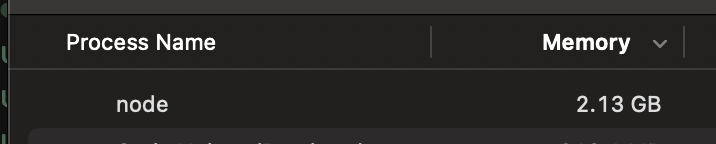

Next, I tried dumping the full index, only to get an error that the JSON blob was too big to write. Oh, and yes, that is $1,080,813$ entries in the reverse index!

```
debug
1080813
file:///Users/yash/code/microsearch/runner.js:84
      fs.writeFile('debug.json', JSON.stringify(Object.fromEntries(index.idx), null, 2));
                                      ^

RangeError: Invalid string length
    at JSON.stringify (<anonymous>)
    at file:///Users/yash/code/microsearch/runner.js:84:39
    at process.processTicksAndRejections (node:internal/process/task_queues:105:5)

Node.js v22.13.0
```

Our goal was to be able to do fullly client-side search on a large dataset. Unfortunately, that is currently sounding like a pipe dream!

## Summary 💬

In this article, we learned what a forward index and reverse index are in a search engine. We also used our intuition on how to find a word in a textbook to develop the data structures and algorithms required to create the forward and reverse index.

## [Next: Workshop - you'll build your search engine!](/blog/search-engine-4)